<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week11/vector_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means - Vector Quantization

## 1. Download the images

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import urllib.request
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from PIL import Image


# --- Download and extract images from GitHub if not already present ---
import requests, zipfile, io, os
image_folder = "images"
if not os.path.exists(image_folder):
    zip_url = "https://github.com/reitezuz/18NES1-2025-/raw/main/week8/conv_images.zip"
    response = requests.get(zip_url)
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall(image_folder)




## 2. Load an image and prepare training dataset

In [97]:
def load_image_as_data(image_path):
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    original_shape = img_array.shape
    T = img_array.reshape((-1, 3)).astype(np.float64) / 256.0
    return T, original_shape, img_array


# File name
#input_image = 'images/conv_images/turtle.png'
input_image = 'images/conv_images/cat.png'

# Create the dataset from the image:
T, original_shape, img_array = load_image_as_data(input_image)

print(T.shape)
print(original_shape)
print(T[0:5])

(66300, 3)
(221, 300, 3)
[[0.90625    0.92578125 0.92578125]
 [0.90625    0.92578125 0.92578125]
 [0.90625    0.92578125 0.92578125]
 [0.90625    0.92578125 0.92578125]
 [0.90625    0.92578125 0.92578125]]


## 3. Cluster the image pixels

In [98]:
def cluster_pixels(T, n_clusters):
    """
    Apply KMeans clustering to the pixel data.
    """
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    idx = kmeans.fit_predict(T)
    centroids = kmeans.cluster_centers_
    return idx, centroids

- set number of clusters:

In [99]:
n_clusters = 15
assignments, centroids = cluster_pixels(T, n_clusters)

print(assignments.shape)
print(centroids.shape)


(66300,)
(15, 3)


## 4. Recreate the imagge, show the quantized image and the color palette

In [100]:
def recreate_image(assignments, centroids, original_shape):
    y = centroids[assignments]
    y = (y * 256).clip(0, 255).astype(np.uint8)
    new_img = y.reshape(original_shape)
    return new_img

quantized_img = recreate_image(assignments, centroids, original_shape)

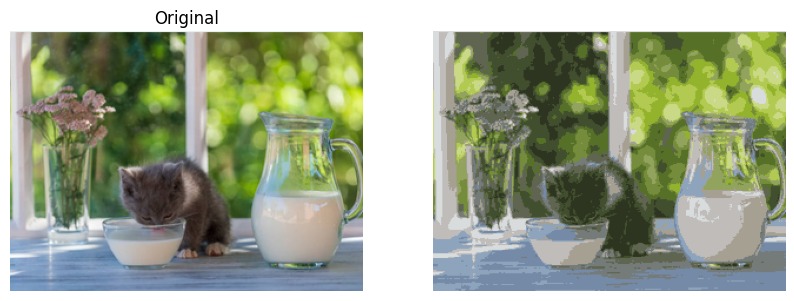

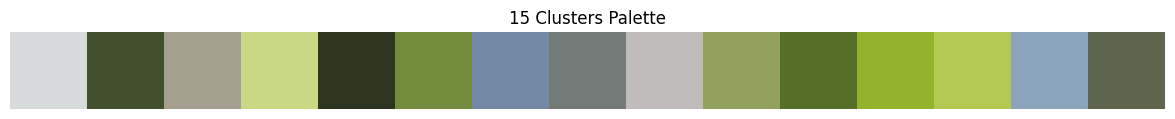

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def show_color_palette(centroids, title='Color Palette'):

    n = len(centroids)
    square_size = 10  # number of pixels per square

    # Create an image of n squares side by side
    palette = np.zeros((square_size, n * square_size, 3), dtype=np.uint8)

    for idx, color in enumerate(centroids):
        color_rgb = (color * 255).clip(0, 255).astype(np.uint8)
        palette[:, idx*square_size:(idx+1)*square_size, :] = color_rgb

    plt.figure(figsize=(n, 1))
    plt.imshow(palette)
    plt.axis('off')
    plt.title(title)
    plt.show()


# Show original and quantized image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(quantized_img)
plt.axis('off')
plt.show()

# Show color palette
show_color_palette(centroids, title=f'{n_clusters} Clusters Palette')


## 5. Save the clustered image

In [102]:
def save_quantized_image(assignments, centroids, original_shape, output_path):
    """
    Save a quantized image based on assignments and centroids.
    """
    y = centroids[assignments]
    y = (y * 256).clip(0, 255).astype(np.uint8)
    new_img_array = y.reshape(original_shape)
    img_out = Image.fromarray(new_img_array)
    img_out.save(output_path)

## Ensure output folder exists
output_folder = 'images_out'
os.makedirs(output_folder, exist_ok=True)
output_image_0 = 'images_out/' + os.path.basename(input_image)
save_quantized_image(assignments, centroids, original_shape, output_image_0)


## 6. Using the same centroids on another image

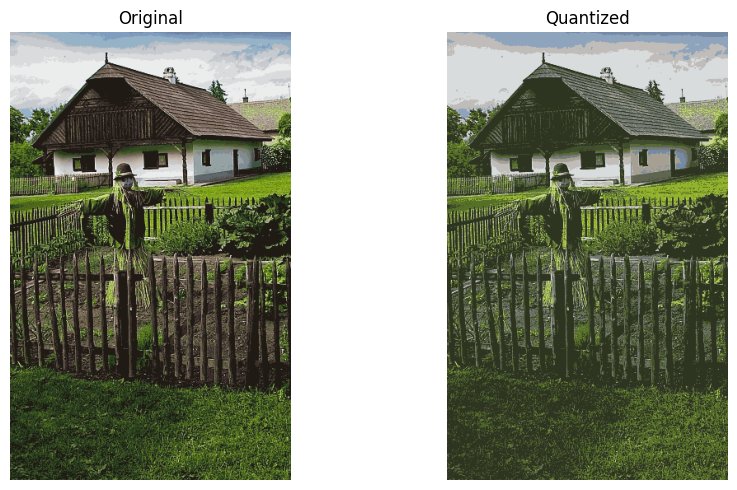

In [103]:
# 2nd image:
second_image = 'images/conv_images/house.png'


T2, original_shape2, img_array_1 = load_image_as_data(second_image)

# Assign each pixel in the new image to the nearest centroid
distances = cdist(T2, centroids, metric='euclidean')
assignments2 = np.argmin(distances, axis=1)

output_image_1 = 'images_out/' + os.path.basename(second_image)
save_quantized_image(assignments2, centroids, original_shape2, output_image_1)


quantized_img_1 = recreate_image(assignments2, centroids, original_shape2)

# Show original and quantized image side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_array_1)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(quantized_img_1)
axes[1].set_title('Quantized')
axes[1].axis('off')

plt.tight_layout()
plt.show()



## 7. Show the results for various number of clusters:

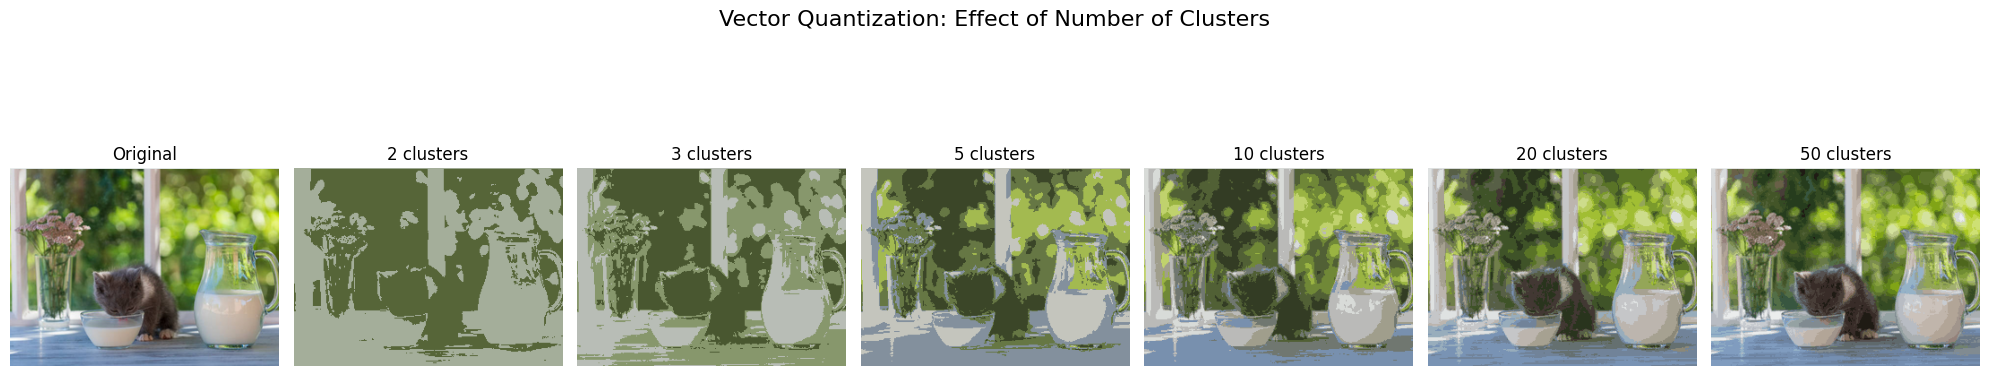

In [104]:
# Cluster sizes to test
cluster_sizes = [2, 3, 5, 10, 20, 50]

# Prepare figure
fig, axes = plt.subplots(1, len(cluster_sizes) + 1, figsize=(20, 5))
fig.suptitle('Vector Quantization: Effect of Number of Clusters', fontsize=16)

# Plot original image
axes[0].imshow(img_array)
axes[0].set_title('Original')
axes[0].axis('off')

# Quantize with different numbers of clusters
for idx, n_clusters in enumerate(cluster_sizes):
    assignments, centroids = cluster_pixels(T, n_clusters)
    quantized_img = recreate_image(assignments, centroids, original_shape)

    # Save output
    output_path = os.path.join(output_folder, f'turtle_{n_clusters}_clusters.bmp')
    Image.fromarray(quantized_img).save(output_path)

    # Plot
    axes[idx + 1].imshow(quantized_img)
    axes[idx + 1].set_title(f'{n_clusters} clusters')
    axes[idx + 1].axis('off')

plt.tight_layout()
plt.show()